In [1458]:
import math
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

In [1459]:
# notes: Constant BCs and Sources go on RHS. Diffusion terms go in matrix

In [1460]:
class Point_Source(object):
    def __init__(self,node,value):
        self.node =node
        self.value =value

In [1461]:
class Continuous_Source(object):
    def __init__(self,x_upper, x_lower, y_upper, y_lower, strength):
        self.x_upper = x_upper
        self.x_lower = x_lower
        self.y_upper = y_upper
        self.y_lower = y_lower
        self.strength = strength

In [1462]:
class Transmissivity(object):
    def __init__(self, Tx=(lambda x, y: 1.0), Ty=(lambda x, y: 1.0)):
        self.Tx = Tx
        self.Ty = Ty
        

In [1463]:
class Grid(object):
    def __init__(self, Lx=1, Ly=1, T=Transmissivity(), point_sources=[], continuous_sources=[], top_BC=0, bottom_BC=0,
                 left_BC=(lambda y: 0), right_BC=(lambda y: 1), left_BC_on=True, right_BC_on=True, type_two_BCs_on=True, num_nodes_per_side = 4):
        self.num_nodes_per_side = num_nodes_per_side
        self.top_BC = top_BC
        self.bottom_BC = bottom_BC
        self.num_elements = ((num_nodes_per_side-1)**2)*2
        self.num_nodes = num_nodes_per_side*num_nodes_per_side
        self.elements = list(range(1,self.num_elements+1))
        self.nodes = list(range(1,self.num_nodes+1))
        self.T = T
        # we make the node values list one longer than it needs to be to not 
        # have to deal with 1 indexing instead of 0 indexing
        self.node_values = [0] * (self.num_nodes+1)
        self.top_edge_nodes = []
        self.bottom_edge_nodes = []
        self.right_edge_nodes = []
        self.left_edge_nodes = []
        self.right_edge_nodes = []
        if left_BC_on:
            for i in range(0,num_nodes_per_side):
                self.left_edge_nodes.append(i*num_nodes_per_side+1)
        if right_BC_on:
            for i in range(0,num_nodes_per_side):
                self.right_edge_nodes.append((i+1)*num_nodes_per_side)
        if type_two_BCs_on:
            for i in range(0,num_nodes_per_side):
                self.top_edge_nodes.append(self.num_nodes-i)
                self.bottom_edge_nodes.append(i+1)
        self.point_sources = point_sources
        self.continuous_sources = continuous_sources
        self.Lx = Lx
        self.Ly = Ly
        self.left_BC = left_BC
        self.right_BC = right_BC
        self.elemental_area = (Lx*Ly)/len(self.elements)

    # We make sure to return these nodes sorted in counter clockwise order
    def nodes_associated_with_element(self, element):
        square = math.floor((float(element)+1.0)/2.0)
        row = math.floor((square-.5)/(self.num_nodes_per_side-1))
        is_upper_triangle = element%2
        lower_left_node = int(square + row)
        upper_right_node = lower_left_node + self.num_nodes_per_side + 1
        third_node = lower_left_node + 1
        if not is_upper_triangle:
            return [lower_left_node,third_node,upper_right_node]
        else:
            third_node = upper_right_node - 1
            return [lower_left_node,upper_right_node,third_node]
    
    def row(self, node):
        return (math.floor((node-1)/self.num_nodes_per_side))
    
    def column(self, node):
        return ((node-1)%self.num_nodes_per_side)

    def node_y(self, node):
        return self.Ly * self.row(node)/(self.num_nodes_per_side-1)
    
    def node_x(self, node):
        return self.Ly * self.column(node)/(self.num_nodes_per_side-1)

    def empty_matrix(self):
        matrix = []
        for _ in self.nodes:
            matrix.append([0]*self.num_nodes)
        return matrix

    # TODO calculate this
    def percent_overlap(continuous_source, element):
        return 1
    
    # need to adjust this for how much of the element is being overlapped by the source
    # For now we assume the continuous source is a constant
    # This can go in the vector not the matrix
    def calculate_continuous_source_term(self, element, continuous_source):
        return self.elemental_area * continuous_source.strength * self.percent_overlap(element, continuous_source)
    
    def assemble_right_hand_side(self):
        vector = [0] * len(self.nodes)
        for node in self.nodes:
            for continuous_source in self.continuous_sources:
                vector[node-1] = vector[node-1] - continuous_source.strength
        # add type 2 BCs
        # # TODO make this variable along edge
        # for node in self.top_edge_nodes:
        #     # For nodes that only have one element below we have to adjust
        #     if self.column(node) == 0 or self.column(node) == self.num_nodes_per_side - 1:
        #         vector[node-1] = vector[node-1] + 0.5*self.Lx/(self.num_nodes_per_side-1)*self.top_BC
        #     else:
        #         vector[node-1] = vector[node-1] + self.Lx/(self.num_nodes_per_side-1)*self.top_BC
        # for node in self.bottom_edge_nodes:
        #     # For nodes that only have one element below we have to adjust
        #     if self.column(node) == 0 or self.column(node) == self.num_nodes_per_side - 1:
        #         vector[node-1] = vector[node-1] + 0.5*self.Lx/(self.num_nodes_per_side-1)*self.bottom_BC
        #     else:
        #         vector[node-1] = vector[node-1] + self.Lx/(self.num_nodes_per_side-1)*self.bottom_BC
        # add type 1 BCs
        for node in self.left_edge_nodes:
            vector[node-1] = self.left_BC(self.node_y(node))
        for node in self.right_edge_nodes:
            vector[node-1] = self.right_BC(self.node_y(node))
        # add point sources
        for point_source in self.point_sources:
            vector[point_source.node-1] = point_source.value
        
                # for node_2 in self.nodes_associated_with_element(element):
                #     for continuous_source in self.continuous_sources:
                #         if node_1 == node_2:
                #             vector[node_1-1] = vector[node_1-1] - continuous_source.strength*self.elemental_area/12
                #         else:
                #             vector[node_1-1] = vector[node_1-1] - continuous_source.strength*self.elemental_area/6
                # # vector[element] += self.calculate_continuous_source_term(element, continuous_source)
        return vector
    
    # TODO ADD variable T
    def calculate_diffusion_term(self, i, j, element_nodes,):
        x = self.node_x(element_nodes[i%3])
        y = self.node_y(element_nodes[i%3])
        term_1 = (self.node_y(element_nodes[(i+1)%3]) - self.node_y(element_nodes[(i+2)%3]))/(2*self.elemental_area)
        term_2 = (self.node_y(element_nodes[(j+1)%3]) - self.node_y(element_nodes[(j+2)%3]))/(2*self.elemental_area)
        term_3 = (self.node_x(element_nodes[(i+2)%3]) - self.node_x(element_nodes[(i+1)%3]))/(2*self.elemental_area)
        term_4 = (self.node_x(element_nodes[(j+2)%3]) - self.node_x(element_nodes[(j+1)%3]))/(2*self.elemental_area)
        return self.T.Tx(x,y)*term_1*term_2 + self.T.Ty(x,y)*term_3*term_4

    def assemble_matrix(self):
        matrix = self.empty_matrix()
        # do elemental integrals
        for element in self.elements:
            element_nodes = self.nodes_associated_with_element(element)
            for i in range(0,len(element_nodes)):
                for j in range(0,len(element_nodes)):
                    contribution = self.calculate_diffusion_term(i, j, element_nodes)
                    matrix[element_nodes[i]-1][element_nodes[j]-1] += contribution
        # add type one BCs
        for node in self.left_edge_nodes:
            matrix[node-1] = [0]*len(self.nodes)
            matrix[node-1][node-1] = 1
        for node in self.right_edge_nodes:
            matrix[node-1] = [0]*len(self.nodes)
            matrix[node-1][node-1] = 1
        # add type 2 BCs

        # add point source/sink terms
        for point_source in self.point_sources:
            matrix[point_source.node-1] = [0]*len(self.nodes)
            matrix[point_source.node-1][point_source.node-1] = 1
        return matrix

    def solve_system(self):
        A = self.assemble_matrix()
        b = self.assemble_right_hand_side()
        self.node_values = [0] + list(np.linalg.solve(A,b))
    
    def print_system(self, title="Graph of node values"):
        printing_grid = np.zeros((self.num_nodes_per_side,self.num_nodes_per_side))
        for node in self.nodes:
            node_value = self.node_values[node]
            y = self.num_nodes_per_side - 1 - math.floor((node-1)/self.num_nodes_per_side)
            x = (node-1) % self.num_nodes_per_side
            printing_grid[y][x] = node_value
        ax = sns.heatmap(printing_grid, linewidth=0.5,cmap="YlGnBu",xticklabels=[],yticklabels=[])
        plt.title(title)
        # plt.set(xticklabels=[],yticklabels=[])
        plt.show()

        


In [1464]:
grid = Grid()

In [1465]:
# Nodes associated with element test
assert grid.nodes_associated_with_element(1) == [1,6,5]
assert grid.nodes_associated_with_element(2) == [1,2,6]
assert grid.nodes_associated_with_element(7) == [5,10,9]
assert grid.nodes_associated_with_element(8) == [5,6,10]

In [1466]:
# Node position calculations test
assert grid.node_y(1) == 0
assert grid.node_x(1) == 0
assert grid.node_y(4) == 0
assert grid.node_x(6) == 1.0/3.0
assert grid.node_y(12) == 2.0/3.0
assert grid.node_y(16) == 1
assert grid.node_x(16) == 1

In [1467]:
# Test I got the boundary condition nodes correct
assert grid.right_edge_nodes == [4,8,12,16]
assert grid.left_edge_nodes == [1,5,9,13]

In [1468]:
matrix = grid.assemble_matrix()
print(matrix)

[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [-9.0, 36.0, -9.0, 0, 0, -18.0, 0.0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, -9.0, 36.0, -9.0, 0, 0, -18.000000000000004, 0.0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0.0, -18.0, 0, 0, -18.0, 72.0, -18.0, 0, 0, -18.0, 0.0, 0, 0, 0, 0, 0], [0, 0.0, -18.000000000000004, 0, 0, -18.0, 72.0, -18.0, 0, 0, -18.000000000000004, 0.0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0.0, -18.0, 0, 0, -18.000000000000004, 72.0, -18.000000000000004, 0, 0, -18.0, 0.0, 0], [0, 0, 0, 0, 0, 0.0, -18.000000000000004, 0, 0, -18.000000000000004, 72.0, -18.000000000000004, 0, 0, -18.000000000000004, 0.0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0.0, -18.0, 0, 0, -9.000000000000004, 36.00000000000001, -9.000000000000004,

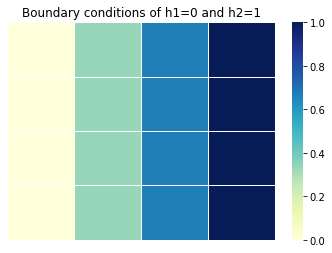

In [1469]:
# Only type 1 bcs on
grid = Grid()
grid.solve_system()
grid.print_system(title="Boundary conditions of h1=0 and h2=1")

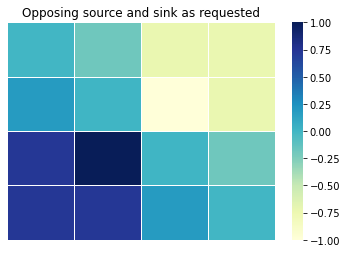

In [1470]:
# Only 
point_sources =[ 
    Point_Source(node=6,value=1),
    Point_Source(node=11,value=-1)
]
def right_BC(y):
    return 0

grid = Grid(point_sources=point_sources,right_BC=right_BC, left_BC_on = False, right_BC_on=False)
grid.solve_system()
grid.print_system(title="Opposing source and sink as requested")

In [1471]:
# # Only 
# point_sources =[ 
#     Point_Source(node=7,value=1),
#     # Point_Source(node=11,value=1)
# ]
# grid = Grid(_point_sources=point_sources, _right_BC=1,type_one_BCs_on = True)

# grid.solve_system()
# grid.print_system()

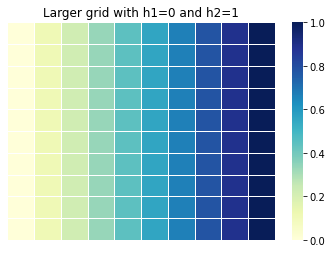

In [1472]:
# Only type 1 bcs only, larger grid
grid = Grid(num_nodes_per_side=10)
grid.solve_system()
grid.print_system(title="Larger grid with h1=0 and h2=1")

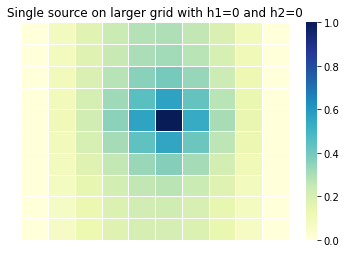

In [1473]:
point_sources =[ 
    Point_Source(node=56, value=1),
    # Point_Source(node=11,value=1)
]
def right_BC(y):
    return 0

grid = Grid(point_sources=point_sources, right_BC=right_BC, num_nodes_per_side=10)

grid.solve_system()
grid.print_system(title="Single source on larger grid with h1=0 and h2=0")

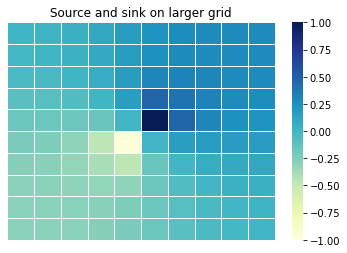

In [1474]:
point_sources =[ 
    Point_Source(node=56,value=1),
    Point_Source(node=45,value=-1)
]
grid = Grid(point_sources=point_sources, left_BC_on = False, right_BC_on=False, num_nodes_per_side=10)

grid.solve_system()
grid.print_system(title="Source and sink on larger grid")

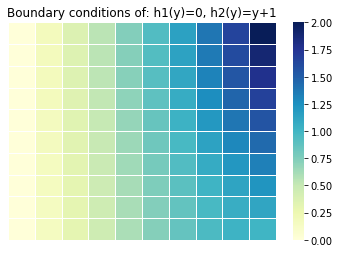

In [1475]:
# Test with variable right boundary condition f(y) = y + 1 and constant left BC = 0
def right_BC(y):
    return 1.0+y

grid = Grid(right_BC=right_BC,num_nodes_per_side=10)

grid.solve_system()
grid.print_system(title="Boundary conditions of: h1(y)=0, h2(y)=y+1")

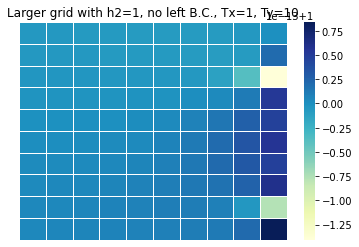

In [1487]:
def Tx(x,y):
    return 1

def Ty(x,y):
    return 10

T = Transmissivity(Tx, Ty)

# Only type 1 bcs only, larger grid
grid = Grid(num_nodes_per_side=10, left_BC_on=False)
grid.solve_system()
grid.print_system(title="Larger grid with h2=1, no left B.C., Tx=1, Ty=10")

In [ ]:
# point_sources =[ 
#     Point_Source(node=56, value=1),
#     # Point_Source(node=11,value=1)
# ]
# def right_BC(y):
#     return 0

# grid = Grid(point_sources=point_sources, right_BC=right_BC, num_nodes_per_side=10)

# grid.solve_system()
# grid.print_system(title="Single source on larger grid with h1=0 and h2=0")

In [1484]:
# TODO This is not working :(
# continuous_sources = [ 
#     Continuous_Source(1,0,1,0,1)
# ]
# grid = Grid(continuous_sources=continuous_sources, left_BC_on = False, right_BC_on=False,num_nodes_per_side=10)

# grid.solve_system()
# grid.print_system()

In [1483]:
# # Testing type 2 BCs that aren't zero, not working
# grid = Grid(left_BC_on = False, right_BC_on=False, top_BC=1,num_nodes_per_side=4)

# grid.solve_system()
# grid.print_system()